<a href="https://colab.research.google.com/github/bdunwh/db/blob/main/Tik3_RSNA_Roboflow_Breakhis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall tenserflow_hub
!pip uninstall tenserflow
!pip uninstall NumPy
!pip uninstall jax
!pip install tensorflow==2.14.0
!pip install tensorflow_hub==0.15.0
!pip install numpy==1.23.5
!pip install jax==0.4.14
!pip install jaxlib==0.4.14


Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/bin/f2py3
    /usr/local/bin/f2py3.11
    /usr/local/lib/python3.11/dist-packages/numpy-1.23.5.dist-info/*
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libopenblas64_p-r0-742d56dc.3.20.so
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.11/dist-packages/numpy/*
Proceed (Y/n)? n
Found existing installation: jax 0.4.14
Uninstalling jax-0.4.14:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/jax-0.4.14.dist-info/*
    /usr/local/lib/python3.11/dist-packages/jax/*
Proceed (Y/n)? n
  Using cached jaxlib-0.4.14-cp311-cp311-manylinux2014_x86_64.whl.metadata (2.0 kB)
Using cached jaxlib-0.4.14-cp311-cp311-manylinux2014_x86_64.whl (73.7 MB)
ERROR: pip's dependency resolver does not currently take into acco

In [2]:
from defs import *

TensorFlow version: 2.14.0
NumPy version: 1.23.5
JAX version: 0.4.14


In [3]:
#RSNA
# Download latest version
path = kagglehub.dataset_download("gauravduttakiit/rsna-screening-mammography-breast-cancer-detection")
# Eğitim ve test CSV dosyalarının tam yollarını oluşturun
train_csv_path = os.path.join(path, "train.csv")
test_csv_path = os.path.join(path, "test.csv")

# Eğitim ve test verilerini yükleyin
train_data = pd.read_csv(train_csv_path)
test_data = pd.read_csv(test_csv_path)

# Görüntü dosyalarının yolu
train_images_dir = os.path.join(path, "output/train")  # 'output/train' içindeki görüntüler
test_images_dir = os.path.join(path, "output/test")   # 'output/test' içindeki görüntüler

# train.csv'deki image_id sütunundan tam yolları oluştur
train_data["image_path"] = train_data.apply(
    lambda row: os.path.join(train_images_dir, f"{row['patient_id']}_{row['image_id']}.png"), axis=1
)


100%|██████████| 0.98G/0.98G [00:06<00:00, 174MB/s]

Extracting files...


In [ ]:
#RSNA EfficientNetB0 için preprocessing ve veri yükleme fonksiyonu

# Eğitim ve doğrulama verilerini bölme (Eğitim için %80, doğrulama için %20)
train_df, val_df = train_test_split(train_data, test_size=0.2, random_state=42)

# Sınıf başına eşit örnek sayısı belirle
sample_per_class = 3500  # Toplam 7000 olacak, her sınıf için 3500 örnek

# Sınıflara göre örnek seç (Eğitim verisi için)
cancer_samples = train_df[train_df["cancer"] == 1].sample(n=sample_per_class, replace=True, random_state=42)
non_cancer_samples = train_df[train_df["cancer"] == 0].sample(n=sample_per_class, replace=False, random_state=42)

# Dengeli eğitim veri seti oluştur
balanced_train_df = pd.concat([cancer_samples, non_cancer_samples]).sample(frac=1, random_state=42)  # Karıştır

# Eğitim ve doğrulama dataset'lerini oluştur
trainRSNA_dataset = prepare_rsna_dataset(balanced_train_df, train_images_dir)
valRSNA_dataset = prepare_rsna_dataset(val_df, train_images_dir)

# Test dataset oluşturma (etiket gerekmez, sadece test için)
test_image_paths = test_data.apply(
    lambda row: os.path.join(test_images_dir, f"{row['patient_id']}_{row['image_id']}.png"),
    axis=1
)
testRSNA_dataset = tf.data.Dataset.from_tensor_slices(test_image_paths)
testRSNA_dataset = testRSNA_dataset.map(lambda x: load_and_preprocess_image(x, 0)).batch(32)  # Etiket 0 çünkü test

# Sonuçları kontrol et
print(f"RSNA Training dataset size: {len(balanced_train_df)}")
print(f"RSNA Validation dataset size: {len(val_df)}")
print(f"RSNA Test dataset size: {len(test_data)}")

In [ ]:
#Roboflow
def get_label_from_path(image_path):
    # Resmin etiketini, dosya yolundaki üst klasörden alıyoruz (0 veya 1)
    return int(image_path.split(os.sep)[-2])
def get_image_paths_and_labels(directory):
    # 'train' dizinindeki alt klasörleri (0 ve 1) tarıyoruz
    image_paths = glob.glob(os.path.join(directory, "*", "*.jpg"))  # Tüm JPG dosyaları (alt klasörler dahil:0 ve 1 alt klasörü var)
    labels = [get_label_from_path(img) for img in image_paths]
    return image_paths, labels

# Download latest version
path_ds = kagglehub.dataset_download("hayder17/breast-cancer-detection")
train_images_dir = "/root/.cache/kagglehub/datasets/hayder17/breast-cancer-detection/versions/1"
# Görüntü dosyalarının yolu
train_images_dir = os.path.join(path_ds, "train")  # 'output/train' içindeki görüntüler
test_images_dir = os.path.join(path_ds, "test")   # 'output/test' içindeki görüntüler
val_images_dir = os.path.join(path_ds, "valid")   # 'output/test' içindeki görüntüler

#  Eğitim ve doğrulama veri kümesini oluştur
train_image_paths, train_labels = get_image_paths_and_labels(train_images_dir)
val_image_paths, val_labels = get_image_paths_and_labels(val_images_dir)

# Eğitim ve doğrulama veri kümesini böl
train_paths, val_paths, train_labels, val_labels = train_test_split(train_image_paths, train_labels, test_size=0.2, random_state=42)

# Datasetleri oluştur
trainRobo_dataset = prepare_roboflow_dataset(train_paths, train_labels)
valRobo_dataset = prepare_roboflow_dataset(val_paths, val_labels)


#  Test dataset (etiket olmadan)
#  Test dataset (etiket olmadan)
test_image_paths, _ = get_image_paths_and_labels(test_images_dir)
test_RoboDataset = prepare_roboflow_dataset(test_image_paths).batch(32)



100%|██████████| 87.2M/87.2M [00:00<00:00, 154MB/s]

Extracting files...


In [ ]:
#BreakHis
# %%
from functools import partial

# BreakHis veri kümesinin yolunu belirleyelim
# Download latest version
path = kagglehub.dataset_download("ambarish/breakhis")
print("Path to dataset files:", path)
import os

print("Dataset path:", path)
print("Klasör içeriği:", os.listdir(path))  # İndirilen klasörün içeriğini göster

# Eğitim ve test CSV dosyalarının tam yollarını oluşturun
data_path = os.path.join(path, "Folds.csv")
class_names = ['malignant', 'benign']
# Eğitim ve test verilerini yükleyin
dataBreak = pd.read_csv(data_path)

dataBreak = dataBreak.rename(columns={'filename': 'path'})
dataBreak['label'] = dataBreak.path.apply(lambda x: x.split('/')[3])
dataBreak['label_int'] = dataBreak.label.apply(lambda x: class_names.index(x))
dataBreak['filename'] = dataBreak.path.apply(lambda x: x.split('/')[-1])

# Eğitim ve test verisini ayırma (Burada test verisini %20 olarak ayarlıyoruz)
test_Breakimages = dataBreak.groupby(by='label').sample(1800)  # Yüzde 20'unu teste aldık
train_images = dataBreak.drop(test_Breakimages.index).reset_index(drop=True)
test_Breakimages = test_Breakimages.reset_index(drop=True)
test_Breakimages['set'] = 'test'

# Eğitim verisi (train_images) ve test verisini (test_Breakimages) yol ekleme
train_Breakimages["path"] = train_Breakimages["path"].astype(str).apply(lambda x: os.path.join(path, "BreaKHis_v1", x))
# Pandas'ın satırda gösterdiği maksimum uzunluğu arttır
pd.set_option('display.max_colwidth', None)

100%|██████████| 3.99G/3.99G [00:24<00:00, 175MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ambarish/breakhis/versions/4
Dataset path: /root/.cache/kagglehub/datasets/ambarish/breakhis/versions/4
Klasör içeriği: ['BreaKHis_v1', 'Folds.csv']
0    /root/.cache/kagglehub/datasets/ambarish/breakhis/versions/4/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-001.png
Name: path, dtype: object


In [ ]:
#Breakhis
print(test_Breakimages.count())
print(train_Breakimages.count())
# fl_model.py dosyasındaki fonksiyonları import et
from fl_prepare import make_validation, load_trains

validation_images, train_images = make_validation(train_images) #genel
trainBreak_dataset, valBreak_dataset = load_trains(train_images, validation_images)


fold         6000
mag          6000
grp          6000
path         6000
label        6000
label_int    6000
filename     6000
set          6000
dtype: int64
fold         33545
mag          33545
grp          33545
path         33545
label        33545
label_int    33545
filename     33545
dtype: int64


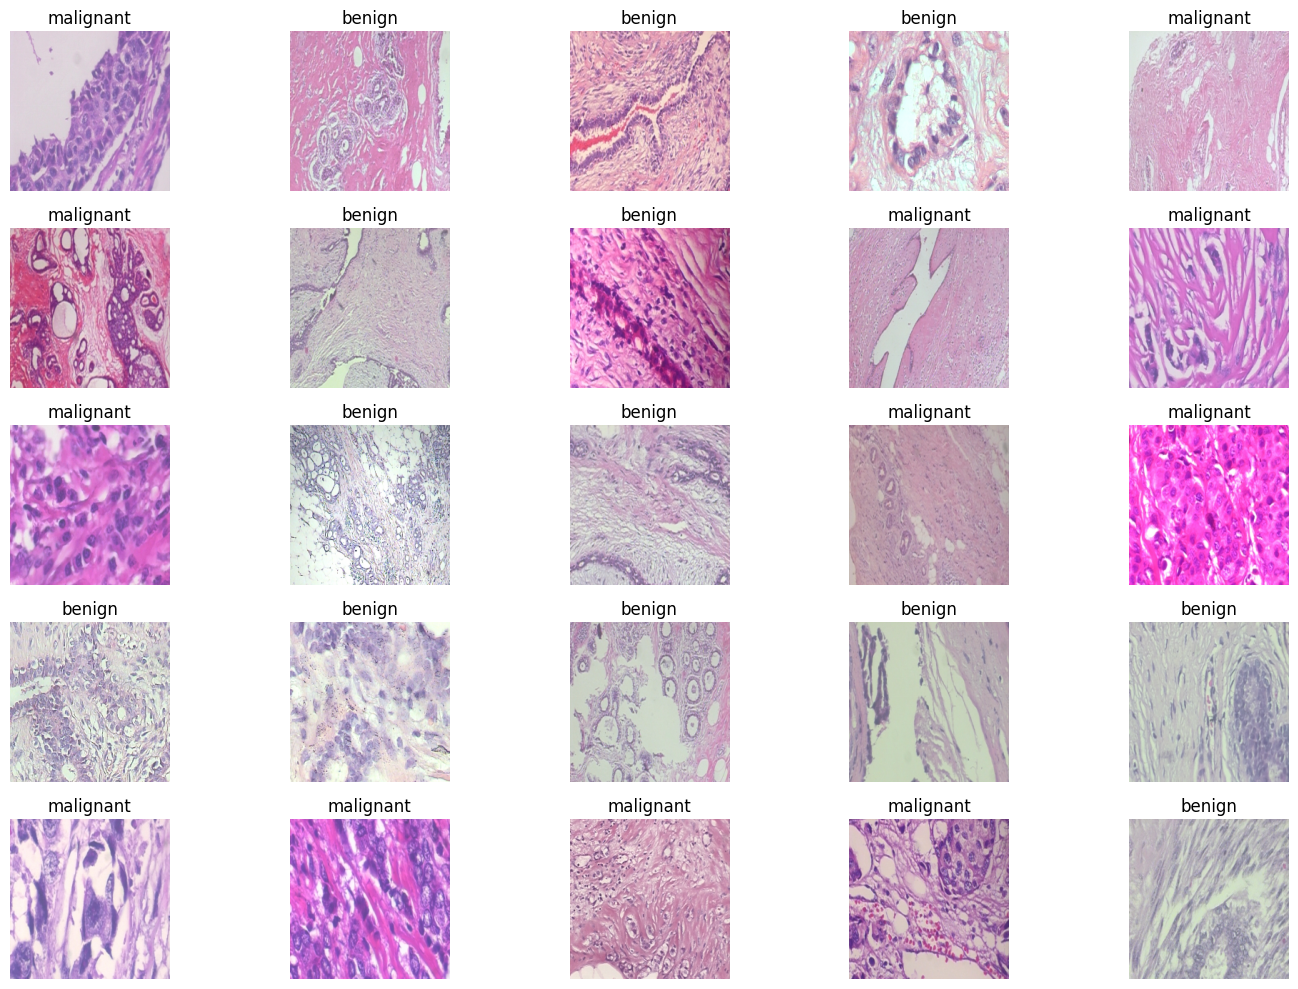

In [ ]:
import matplotlib.pyplot as plt

# Görselleri görselleştirmek için fonksiyon
def view_image(ds, col=5, row=5, size=(15, 10)):
    plt.figure(figsize=size)
    plt.subplots_adjust(wspace=0.05, hspace=0.15)  # Subplotlar arası boşluk ayarı

    for images, labels in ds.take(1):  # tf.data.Dataset içinden bir batch al
        images, labels = images.numpy(), labels.numpy()  # Tensörleri numpy'a çevir

        for i in range(col * row):
            ax = plt.subplot(row, col, i + 1)  # Subplot matrisini ayarla
            plt.imshow(images[i].astype("uint8"))  # Görüntüyü uygun formata çevirerek göster

            plt.title(class_names[int(labels[i])])  # Sınıf ismini ekle
            plt.axis("off")  # Eksenleri kapat

    plt.tight_layout()  # Görsellerin hizasını düzelt
    plt.show()  # Görselleri göster

# Fonksiyonu çağır
view_image(trainBreak_dataset)

In [ ]:

# 3 farklı client için veri setleri
client1_images = trainBreak_dataset
client2_images = trainRobo_dataset #epochs 150 olmalı
client3_images = trainRSNA_dataset


val_client1_images = valBreak_dataset
val_client2_images = valRobo_dataset
val_client3_images = valRSNA_dataset


In [ ]:
#RSNA İÇİN DENENECEK:klasik federe EFFICIENTNET
import time
start = time.time()
from fl_model import make_nn_model
# **2. Klasik Federated Learning Modelini Eğitme**
client3_images = trainRSNA_dataset
val_client3_images = valRSNA_dataset

class F1ScoreCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}

        # Eğitim F1-score hesaplama
        precision = logs.get('precision', 0)
        recall = logs.get('recall', 0)
        f1_score = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

        # Validation (Doğrulama) F1-score hesaplama
        val_precision = logs.get('val_precision', 0)
        val_recall = logs.get('val_recall', 0)
        val_f1_score = 2 * (val_precision * val_recall) / (val_precision + val_recall + tf.keras.backend.epsilon())

        # Ekrana bas
        print(f"Epoch {epoch + 1}: Train F1-score = {f1_score:.4f}, Val F1-score = {val_f1_score:.4f}")

        # Loglara ekle
        logs['f1_score'] = f1_score
        logs['val_f1_score'] = val_f1_score
#**Federated Learning Modeli Eğitme**
def train_federated_learning_model(model_nn, client_images, val_client_images, model_checkpoint, csv_logger, img_size=224, batch_size=32, epochs=10, trainb=False):
    metrics = ['accuracy', Precision(name='precision'), Recall(name='recall')]

    # İstemci modeli
    client_model = make_nn_model(img_size, trainb)
    client_model.compile(optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-4), loss='binary_crossentropy', metrics=metrics)

    # Modeli eğitme
    train_history = client_model.fit(client_images, epochs=epochs, batch_size=batch_size, verbose=1,
                                     callbacks=[model_checkpoint, csv_logger,ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6), F1ScoreCallback()],
                                     validation_data=val_client_images)


     # **Federated Averaging (FedAvg) Güncellemesi**
    new_weights = [(w1 + w2) / 2 for w1, w2 in zip(client_model.get_weights(), model_nn.get_weights())]
    model_nn.set_weights(new_weights)
    model_nn.save_weights('model_fl_jlbb.h5')

    return model_nn, [train_history]

model_name = "efficientnetv2-b0"
BATCH_SIZE = 32
IMG_SIZE =224
model_handle = model_handle_map.get(model_name)
# Model checkpoint ve log ayarları
model_checkpoint = ModelCheckpoint('model.h5', save_best_only=True, save_weights_only=True)
csv_logger = CSVLogger('RSNA_logs.csv', append=True)
# client1
model_nn = make_nn_model(IMG_SIZE,trainb=False)
model_nn,train_history=train_federated_learning_model(model_nn,client3_images, val_client3_images,model_checkpoint,csv_logger,epochs=10)


end = time.time()
print('Time Taken: %.3f seconds' % (end-start))

ERROR:jax._src.xla_bridge:Jax plugin configuration error: Plugin module %s could not be loaded
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/xla_bridge.py", line 428, in discover_pjrt_plugins
    plugin_module = importlib.import_module(plugin_module_name)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 1204, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1176, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1147, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 690, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 940, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_r

KeyboardInterrupt: 

In [ ]:
#yeni manuel f1 bu çalıştırılacak sadece client3 denenecek ve süresi var olan süreye eklenecek
import numpy as np
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import f1_score
# **2. Klasik Federated Learning Modelini Eğitme**

class F1ScoreCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}

        # Eğitim F1-score hesaplama
        precision = logs.get('precision', 0)
        recall = logs.get('recall', 0)
        f1_score = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

        # Validation (Doğrulama) F1-score hesaplama
        val_precision = logs.get('val_precision', 0)
        val_recall = logs.get('val_recall', 0)
        val_f1_score = 2 * (val_precision * val_recall) / (val_precision + val_recall + tf.keras.backend.epsilon())

        # Ekrana bas
        print(f"Epoch {epoch + 1}: Train F1-score = {f1_score:.4f}, Val F1-score = {val_f1_score:.4f}")

        # Loglara ekle
        logs['f1_score'] = f1_score
        logs['val_f1_score'] = val_f1_score
#**Federated Learning Modeli Eğitme**
def train_federated_learning_model(model_nn, client_images, val_client_images, model_checkpoint, csv_logger, img_size=224, batch_size=32, epochs=10, trainb=False):
    metrics = ['accuracy', Precision(name='precision'), Recall(name='recall')]

    # İstemci modeli
    client_model = make_nn_model(img_size, trainb)
    client_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

    # Modeli eğitme
    train_history = client_model.fit(client_images, epochs=epochs, batch_size=batch_size, verbose=1,
                                     callbacks=[model_checkpoint, csv_logger, F1ScoreCallback()],
                                     validation_data=val_client_images)

    # **Federated Averaging (FedAvg) - İlk Güncelleme**
    #new_weights = []
    #for layer_index in range(len(model_nn.get_weights())):
    #    new_layer_weights = np.mean([client_model.get_weights()[layer_index], model_nn.get_weights()[layer_index]], axis=0)
    #    new_weights.append(new_layer_weights)

    #model_nn.set_weights(new_weights)
    #model_nn.save_weights('model_fl_jlbb.h5')

     # **Federated Averaging (FedAvg) Güncellemesi**
    new_weights = [(w1 + w2) / 2 for w1, w2 in zip(client_model.get_weights(), model_nn.get_weights())]
    model_nn.set_weights(new_weights)
    model_nn.save_weights('model_fl_jlbb.h5')

    return model_nn, [train_history]

#**Federated Learning Modeli Eğitme**
def train_federated_learning_modelRSNA(model_nn, client_images, val_client_images, model_checkpoint, csv_logger, img_size=224, batch_size=32, epochs=10, trainb=False):
    metrics = ['accuracy']
    #metrics = ['accuracy']

    # İstemci modeli
    client_model = make_nn_model(img_size, trainb)
    client_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

    # Modeli eğitme
    train_history = client_model.fit(client_images, epochs=epochs, batch_size=batch_size, verbose=1,
                                 callbacks=[model_checkpoint, csv_logger],
                                 validation_data=val_client_images)

    # **Federated Averaging (FedAvg) - İlk Güncelleme**
    #new_weights = []
    #for layer_index in range(len(model_nn.get_weights())):
    #    new_layer_weights = np.mean([client_model.get_weights()[layer_index], model_nn.get_weights()[layer_index]], axis=0)
    #    new_weights.append(new_layer_weights)

    #model_nn.set_weights(new_weights)
    #model_nn.save_weights('model_fl_jlbb.h5')

     # **Federated Averaging (FedAvg) Güncellemesi**
    new_weights = [(w1 + w2) / 2 for w1, w2 in zip(client_model.get_weights(), model_nn.get_weights())]
    model_nn.set_weights(new_weights)
    model_nn.save_weights('model_fl_jlbb.h5')

    return model_nn, [train_history]

In [ ]:
#fedcycle mobilenet
import os, time, tqdm
from tensorflow.keras.callbacks import CSVLogger
import numpy as np
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import f1_score
# **2. Klasik Federated Learning Modelini Eğitme**

class F1ScoreCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}

        # Eğitim F1-score hesaplama
        precision = logs.get('precision', 0)
        recall = logs.get('recall', 0)
        f1_score = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

        # Validation (Doğrulama) F1-score hesaplama
        val_precision = logs.get('val_precision', 0)
        val_recall = logs.get('val_recall', 0)
        val_f1_score = 2 * (val_precision * val_recall) / (val_precision + val_recall + tf.keras.backend.epsilon())

        # Ekrana bas
        print(f"Epoch {epoch + 1}: Train F1-score = {f1_score:.4f}, Val F1-score = {val_f1_score:.4f}")

        # Loglara ekle
        logs['f1_score'] = f1_score
        logs['val_f1_score'] = val_f1_score

model_name = "mobilenet_v2_100_224"
model_handle = model_handle_map.get(model_name)
IMG_SIZE = model_image_size.get(model_name, 224)
BATCH_SIZE = 32
EPOCHS = 10
start = time.time()
tf.keras.backend.clear_session()
# making model checkpoints
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('model_fedcycle_rsna.weights.h5', save_best_only=True,save_weights_only=True)
#metrics = ['accuracy']
metrics = ['accuracy', Precision(name='precision'), Recall(name='recall')]
# model logs
csv_logger = CSVLogger('cnn_fedcycle_rsna_logs.csv', append=True)

# Modeli oluşturma fonksiyonu
def create_compiled_model():
    model = make_nn_model(IMG_SIZE,trainb=False)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    return model


model_nn = create_compiled_model()


# FedCycle Eğitim Fonksiyonu
def train_client_model(client_model, client_images, val_client_images):
    client_model.fit(client_images, epochs=1, batch_size=32, verbose=1, validation_data=val_client_images,
                     callbacks=[model_checkpoint, csv_logger, F1ScoreCallback()])
    return client_model.get_weights()

#Her istemci için ayrı model oluştur (dağıtılmış strateji kullanmadan)
client1_model = create_compiled_model()
client2_model = create_compiled_model()
client3_model = create_compiled_model()

# Ana modelin ağırlıklarını istemcilere aktar
client1_model.set_weights(model_nn.get_weights())
client2_model.set_weights(model_nn.get_weights())
client3_model.set_weights(model_nn.get_weights())
# FedCycle Eğitim Döngüsü
for ind in range(150):
    print(f"Epoch {ind+1}/150 - Federated Training")

    if ind < 21:
      # İstemcileri eğit
      weights1 = train_client_model(client1_model, client1_images, val_client1_images)
      # Federated Averaging (FedAvg) - Ağırlıkları Güncelleme
      new_weights = []
      for layer_index in range(len(model_nn.get_weights())):
          avg_weights = np.mean([weights1[layer_index], model_nn.get_weights()[layer_index]], axis=0)
          new_weights.append(avg_weights)

      model_nn.set_weights(new_weights)
      model_nn.save_weights('model_fedcycle_parallel_rsna.h5')
      if ind == 20: print("Client1 Bitti")

    weights2 = train_client_model(client2_model, client2_images, val_client2_images)
     # Federated Averaging (FedAvg) - Ağırlıkları Güncelleme
    new_weights = []
    for layer_index in range(len(model_nn.get_weights())):
        avg_weights = np.mean([weights2[layer_index], model_nn.get_weights()[layer_index]], axis=0,dtype=np.float32)
        new_weights.append(avg_weights)

    model_nn.set_weights(new_weights)
    model_nn.save_weights('model_fedcycle_parallel_rsna.h5')

    if ind < 11:
      weights3 = train_client_model(client3_model, client3_images, val_client3_images)
       # Federated Averaging (FedAvg) - Ağırlıkları Güncelleme
      new_weights = []
      for layer_index in range(len(model_nn.get_weights())):
          avg_weights = np.mean([weights3[layer_index], model_nn.get_weights()[layer_index]], axis=0)
          new_weights.append(avg_weights)

      model_nn.set_weights(new_weights)
      model_nn.save_weights('model_fedcycle_parallel_rsna.h5')
      if ind == 10: print("Client3 Bitti")


end = time.time()
print('FedCycle Model Time Taken: %.3f seconds' % (end - start))

Making our deep cnn model.....
Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base (KerasLayer)           (None, 1280)              2257984   
                                                                 
 fc1 (Dense)                 (None, 512)               655872    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 fc2 (Dense)                 (None, 128)               65664     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)         

In [ ]:
#fedcycle efficientnet
import os, time, tqdm
from tensorflow.keras.callbacks import CSVLogger
class F1ScoreCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}

        # Eğitim F1-score hesaplama
        precision = logs.get('precision', 0)
        recall = logs.get('recall', 0)
        f1_score = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

        # Validation (Doğrulama) F1-score hesaplama
        val_precision = logs.get('val_precision', 0)
        val_recall = logs.get('val_recall', 0)
        val_f1_score = 2 * (val_precision * val_recall) / (val_precision + val_recall + tf.keras.backend.epsilon())

        # Ekrana bas
        print(f"Epoch {epoch + 1}: Train F1-score = {f1_score:.4f}, Val F1-score = {val_f1_score:.4f}")

        # Loglara ekle
        logs['f1_score'] = f1_score
        logs['val_f1_score'] = val_f1_score
model_name = "efficientnetv2-b0"
#model_name = "mobilenet_v2_100_224"
model_handle = model_handle_map.get(model_name)
IMG_SIZE = model_image_size.get(model_name, 224)
BATCH_SIZE = 32
EPOCHS = 10
start = time.time()
tf.keras.backend.clear_session()
# making model checkpoints
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('model_fedcycle_rsna.h5', save_best_only=True,save_weights_only=True)
#metrics = ['accuracy']
metrics = ['accuracy', Precision(name='precision'), Recall(name='recall')]
# model logs
csv_logger = CSVLogger('cnn_fedcycle_rsna_logs.csv', append=True)

# Modeli oluşturma fonksiyonu
def create_compiled_model():
    model = make_nn_model(IMG_SIZE,trainb=False)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    return model


model_nn = create_compiled_model()


# FedCycle Eğitim Fonksiyonu
def train_client_model(client_model, client_images, val_client_images):
    client_model.fit(client_images, epochs=1, batch_size=32, verbose=1, validation_data=val_client_images,
                     callbacks=[model_checkpoint, csv_logger, F1ScoreCallback()])
    return client_model.get_weights()

#Her istemci için ayrı model oluştur (dağıtılmış strateji kullanmadan)
client1_model = create_compiled_model()
client2_model = create_compiled_model()
client3_model = create_compiled_model()

# Ana modelin ağırlıklarını istemcilere aktar
client1_model.set_weights(model_nn.get_weights())
client2_model.set_weights(model_nn.get_weights())
client3_model.set_weights(model_nn.get_weights())
# FedCycle Eğitim Döngüsü
for ind in range(150):
    print(f"Epoch {ind+1}/150 - Federated Training")

    if ind < 21:
      # İstemcileri eğit
      weights1 = train_client_model(client1_model, client1_images, val_client1_images)
      # Federated Averaging (FedAvg) - Ağırlıkları Güncelleme
      new_weights = []
      for layer_index in range(len(model_nn.get_weights())):
          avg_weights = np.mean([weights1[layer_index], model_nn.get_weights()[layer_index]], axis=0)
          new_weights.append(avg_weights)

      model_nn.set_weights(new_weights)
      model_nn.save_weights('model_fedcycle_parallel_rsna.h5')
      if ind == 20: print("Client1 Bitti")

    weights2 = train_client_model(client2_model, client2_images, val_client2_images)
     # Federated Averaging (FedAvg) - Ağırlıkları Güncelleme
    new_weights = []
    for layer_index in range(len(model_nn.get_weights())):
        avg_weights = np.mean([weights2[layer_index], model_nn.get_weights()[layer_index]], axis=0,dtype=np.float32)
        new_weights.append(avg_weights)

    model_nn.set_weights(new_weights)
    model_nn.save_weights('model_fedcycle_parallel_rsna.h5')

    if ind < 11:
      weights3 = train_client_model(client3_model, client3_images, val_client3_images)
       # Federated Averaging (FedAvg) - Ağırlıkları Güncelleme
      new_weights = []
      for layer_index in range(len(model_nn.get_weights())):
          avg_weights = np.mean([weights3[layer_index], model_nn.get_weights()[layer_index]], axis=0)
          new_weights.append(avg_weights)

      model_nn.set_weights(new_weights)
      model_nn.save_weights('model_fedcycle_parallel_rsna.h5')
      if ind == 10: print("Client3 Bitti")


end = time.time()
print('FedCycle Model Time Taken: %.3f seconds' % (end - start))

Making our deep cnn model.....
Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base (KerasLayer)           (None, 1280)              5919312   
                                                                 
 fc1 (Dense)                 (None, 512)               655872    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 fc2 (Dense)                 (None, 128)               65664     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)         

In [ ]:
#klasik federe EFFICIENTNET
import time
start = time.time()
from tensorflow.keras.layers import Input, Dense, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, LambdaCallback
from tensorflow.keras.metrics import Precision, Recall
model_name = "efficientnetv2-b0"
BATCH_SIZE = 32
IMG_SIZE =224
model_handle = model_handle_map.get(model_name)
# Model checkpoint ve log ayarları
model_checkpoint = ModelCheckpoint('model.h5', save_best_only=True, save_weights_only=True)
csv_logger = CSVLogger('RSNA_logs.csv', append=True)
# client1
model_nn = make_nn_model(IMG_SIZE,trainb=False)
model_nn,train_history=train_federated_learning_model(model_nn,client1_images, val_client1_images,model_checkpoint,csv_logger,epochs=20)
model_nn,train_history=train_federated_learning_model(model_nn,client2_images, val_client2_images,model_checkpoint,csv_logger,epochs=150)
model_nn,train_history=train_federated_learning_model(model_nn,client3_images, val_client3_images,model_checkpoint,csv_logger,epochs=10)



# final fit the model
#metrics = ['accuracy', Precision(name='precision'), Recall(name='recall')]
#model_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)
#train_history2 = model_nn.fit(client2_images, epochs=10, batch_size=BATCH_SIZE, verbose=1,
#                            callbacks=[model_checkpoint, csv_logger], validation_data=val_client2_images)

end = time.time()
print('Time Taken: %.3f seconds' % (end-start))

Making our deep cnn model.....
Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base (KerasLayer)           (None, 1280)              5919312   
                                                                 
 fc1 (Dense)                 (None, 512)               655872    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 fc2 (Dense)                 (None, 128)               65664     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)         

In [ ]:
#klasik federe MOBILENET
import time
start = time.time()
from tensorflow.keras.layers import Input, Dense, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, LambdaCallback
from tensorflow.keras.metrics import Precision, Recall
model_name = "mobilenet_v2_100_224"
BATCH_SIZE = 32
IMG_SIZE =224
model_handle = model_handle_map.get(model_name)
# Model checkpoint ve log ayarları
model_checkpoint = ModelCheckpoint('model.h5', save_best_only=True, save_weights_only=True)
csv_logger = CSVLogger('RSNA_logs.csv', append=True)
# client1
model_nn = make_nn_model(IMG_SIZE,trainb=False)
model_nn,train_history=train_federated_learning_model(model_nn,client1_images, val_client1_images,model_checkpoint,csv_logger,epochs=20)
model_nn,train_history=train_federated_learning_model(model_nn,client2_images, val_client2_images,model_checkpoint,csv_logger,epochs=150)
model_nn,train_history=train_federated_learning_model(model_nn,client3_images, val_client3_images,model_checkpoint,csv_logger,epochs=10)



# final fit the model
#metrics = ['accuracy', Precision(name='precision'), Recall(name='recall')]
#model_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)
#train_history2 = model_nn.fit(client2_images, epochs=10, batch_size=BATCH_SIZE, verbose=1,
#                            callbacks=[model_checkpoint, csv_logger], validation_data=val_client2_images)

end = time.time()
print('Time Taken: %.3f seconds' % (end-start))

Making our deep cnn model.....
Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base (KerasLayer)           (None, 1280)              2257984   
                                                                 
 fc1 (Dense)                 (None, 512)               655872    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 fc2 (Dense)                 (None, 128)               65664     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)         